In [1]:
import json

import pandas as pd
import numpy as np
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt


from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches


from nilearn import plotting
from nilearn.image import new_img_like, smooth_img
from nilearn.datasets import load_mni152_template

from src.utils.data import *
from src.utils.plots import *
from src.utils.sampling import *
from src.utils.memory_management import *
from src.utils.statistics_utils import *

# Set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a console handler
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
# Add the handler to the logger
logger.addHandler(sh)

from src.configs.config_parser import PathConfigParser, data_config_file, project_root

# Configs Directory
parser = PathConfigParser(str(data_config_file))
parser.load()

# Data Paths
PROCESSED_DATA_PATH = project_root / parser.get("data_paths", {}).get("processed_data")
GE_PATH = parser.get("data_paths", {}).get("brain_regions_genes_ge")
PROCESSED_DONORS_GE_PATH = PROCESSED_DATA_PATH / GE_PATH

OUTPUT_DATA = project_root / parser.get("data_paths", {}).get("output_data")

# Donors_ids
DONORS_IDS = parser.get("donors_ids")

Loading main dataframe

In [2]:
meta_donor_df_filtered = load_df_from_csv(PROCESSED_DONORS_GE_PATH / Path("meta_donor_filtered.csv"))
meta_donor_df_filtered["gene_expression_values"] = meta_donor_df_filtered["gene_expression_values"].apply(json.loads)
logger.info(meta_donor_df_filtered["gene_expression_values"][0][0])

3.4665720939923


Stats dataframe

In [3]:
stats_df = load_df_from_csv(OUTPUT_DATA / Path('df_stats.csv'))
df =  stats_df.copy()
df.head(3)

brain_region  gene_id  sum_expression  effect_size_8  p-value_8   power_8  \
0          4012     2541     7305.189875       0.723958   0.039062  0.579479   
1          4013     1259     9883.385544       0.576161   0.125000  0.431013   
2          4013     2541    12655.801370       0.716566   0.054688  0.572157   

   t_stat_8  effect_size_16  p-value_16  power_16  ...  power_256  t_stat_256  \
0      31.0        0.170152    0.231873  0.159962  ...   0.988638     21436.0   
1      27.0       -0.327191    0.798126  0.001882  ...   0.991683     21943.0   
2      30.0        0.205089    0.247711  0.194567  ...   0.999900     22748.0   

   effect_size_512   p-value_512  power_512  t_stat_512  effect_size_1024  \
0         0.179155  8.732317e-07   0.991882     81676.0          0.285270   
1         0.152272  4.490161e-06   0.963761     80536.0          0.088223   
2         0.324791  3.459548e-14   1.000000     90748.0          0.264883   

   p-value_1024  power_1024  t_stat_1024  
0  1.100408e-22    1.000000     354526.0  
1  1.216660e-05    0.880289     302356.0  
2  9.052327e-20    1.000000     347825.0  

[3 rows x 35 columns]

### Averaging MNI Locations per Brain Region

In [4]:
import re
# Access paths
RAW_DATA_PATH = project_root / parser.get("data_paths", {}).get("raw_data") 

donor_pattern = r"^normalized_microarray_donor\d+$"
donor_dirs = [d for d in RAW_DATA_PATH.iterdir() if d.is_dir() and re.match(donor_pattern, d.name)]

donors_sa = []
for donor_path in donor_dirs:
    # Processing path
    logger.info(f"Processing data of {donor_path}")
    donors_sa.append(load_df_from_csv(donor_path / "SampleAnnot.csv"))

donors_sa_df=pd.concat(donors_sa)
donors_sa_df.head(3)

Processing data of /home/affectiva/git/Gene-Expression-Analysis/data/raw/normalized_microarray_donor10021
Processing data of /home/affectiva/git/Gene-Expression-Analysis/data/raw/normalized_microarray_donor14380
Processing data of /home/affectiva/git/Gene-Expression-Analysis/data/raw/normalized_microarray_donor9861
Processing data of /home/affectiva/git/Gene-Expression-Analysis/data/raw/normalized_microarray_donor15496
Processing data of /home/affectiva/git/Gene-Expression-Analysis/data/raw/normalized_microarray_donor12876
Processing data of /home/affectiva/git/Gene-Expression-Analysis/data/raw/normalized_microarray_donor15697


structure_id  slab_num  well_id slab_type structure_acronym  \
0          4322        10     5705        CX                Cl   
1          4291        10     5713        CX               Acb   
2          4292        10     5721        CX               Acb   

             structure_name  polygon_id  mri_voxel_x  mri_voxel_y  \
0           claustrum, left      978619          120           91   
1   nucleus accumbens, left      998603          103           96   
2  nucleus accumbens, right      998604           86           95   

   mri_voxel_z  mni_x  mni_y  mni_z  
0           71  -29.2    5.8   -2.6  
1           71  -10.1    5.9   -8.4  
2           69    8.9    8.5   -7.4

Averaging the mni coordinates for every brain region

In [5]:
average_mni = donors_sa_df.groupby('structure_id')[['mni_x', 'mni_y', 'mni_z']].mean().reset_index()

average_mei = donors_sa_df.groupby('structure_id')[['mri_voxel_x', 'mri_voxel_y', 'mri_voxel_z']].mean().reset_index()

print(average_mni.head(3))

   structure_id      mni_x     mni_y      mni_z
0          4012 -37.463636 -0.681818  44.600000
1          4013 -36.578947 -7.142105  58.152632
2          4014 -45.938889 -9.155556  43.105556


Loadin Stats Per CLuster

In [6]:
OUTPUT_DATA = project_root / parser.get("data_paths", {}).get("output_data")
cluster_0_stats = load_df_from_csv(OUTPUT_DATA / Path('df_stats_cluster_0.csv'))
cluster_1_stats = load_df_from_csv(OUTPUT_DATA / Path('df_stats_cluster_1.csv'))
cluster_2_stats = load_df_from_csv(OUTPUT_DATA / Path('df_stats_cluster_2.csv'))

df_stats = load_df_from_csv(OUTPUT_DATA / Path('df_stats.csv'))

range_with_powers_of_two = [2**i for i in range(3, 9)]

Averaging p-values per Clusters

In [7]:
columns = [f"p-value_{sample_size}" for sample_size in range_with_powers_of_two]

cluster_0_stats_br_p = cluster_0_stats.groupby('brain_region')[columns].mean().reset_index()
cluster_1_stats_br_p = cluster_1_stats.groupby('brain_region')[columns].mean().reset_index()
cluster_2_stats_br_p = cluster_2_stats.groupby('brain_region')[columns].mean().reset_index()

df_stats_br_p = df_stats.groupby('brain_region')[columns].mean().reset_index()
df_stats_br_p.head(3)

brain_region  p-value_8  p-value_16  p-value_32  p-value_64  p-value_128  \
0          4012   0.039062    0.231873    0.416020    0.417883     0.006518   
1          4013   0.089844    0.522919    0.618387    0.198787     0.067133   
2          4014   0.351562    0.706505    0.699557    0.792680     0.440868   

    p-value_256  
0  1.298671e-05  
1  9.249877e-07  
2  3.209983e-04

## Merging Coordinates with P-Values Data

In [8]:
# Instead of taking the mean, keep all coordinates for each structure
all_coordinates = donors_sa_df.groupby('structure_id').agg({
    'mni_x': list,
    'mni_y': list,
    'mni_z': list
}).reset_index()

# Function to explode the lists of coordinates back into rows
def expand_coordinates(row):
    return pd.DataFrame({
        'structure_id': [row['structure_id']] * len(row['mni_x']),
        'mni_x': row['mni_x'],
        'mni_y': row['mni_y'],
        'mni_z': row['mni_z']
    })

# Expand the coordinates
all_coordinates_expanded = pd.concat(
    [expand_coordinates(row) for _, row in all_coordinates.iterrows()],
    ignore_index=True
)




# Merge cluster data with MNI coordinates
cluster1_p = cluster_0_stats_br_p.merge(all_coordinates_expanded, left_on='brain_region', right_on='structure_id')
cluster2_p = cluster_1_stats_br_p.merge(all_coordinates_expanded, left_on='brain_region', right_on='structure_id')
cluster3_p = cluster_2_stats_br_p.merge(all_coordinates_expanded, left_on='brain_region', right_on='structure_id')

df_stats_br_mni_p = df_stats_br_p.merge(all_coordinates_expanded, left_on='brain_region', right_on='structure_id')

df_p = df_stats_br_mni_p.copy()
df_p.head(3)


brain_region  p-value_8  p-value_16  p-value_32  p-value_64  p-value_128  \
0          4012   0.039062    0.231873     0.41602    0.417883     0.006518   
1          4012   0.039062    0.231873     0.41602    0.417883     0.006518   
2          4012   0.039062    0.231873     0.41602    0.417883     0.006518   

   p-value_256  structure_id  mni_x  mni_y  mni_z  
0     0.000013          4012  -50.7    7.3   22.0  
1     0.000013          4012  -36.2   -1.3   50.0  
2     0.000013          4012  -49.6    7.4   22.0

### P-Value on Brain Regions

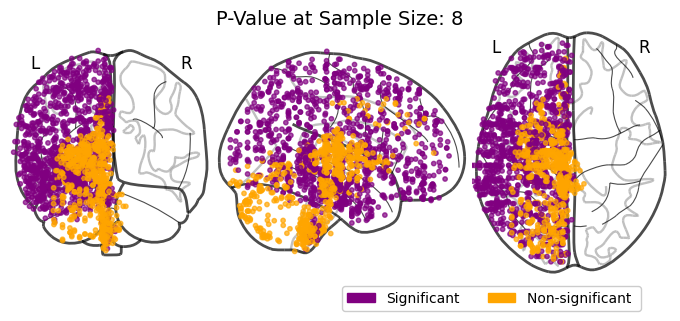

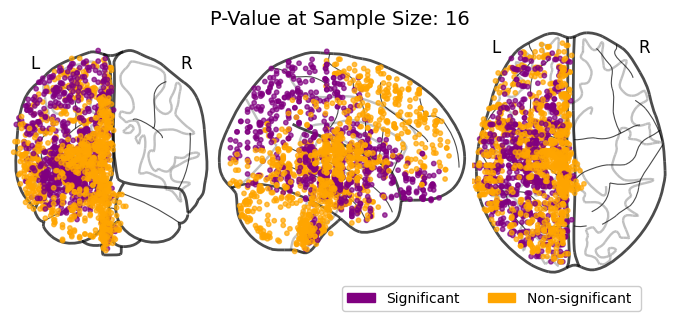

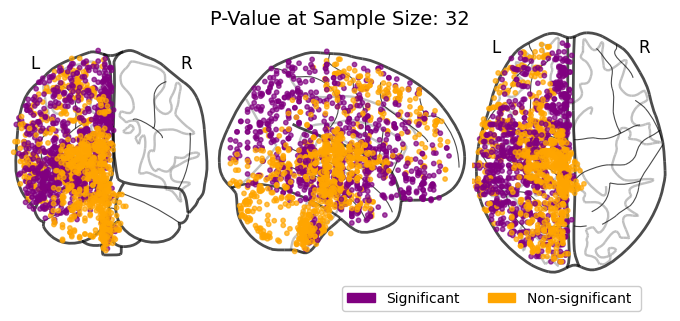

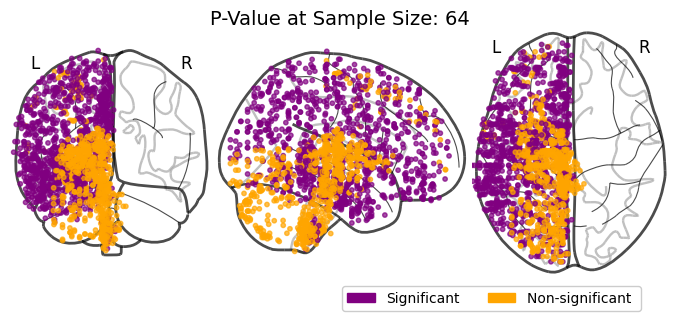

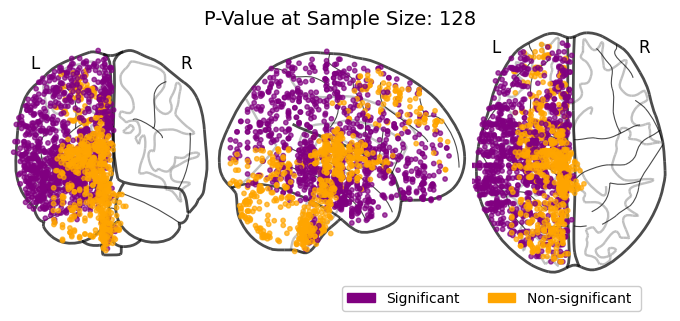

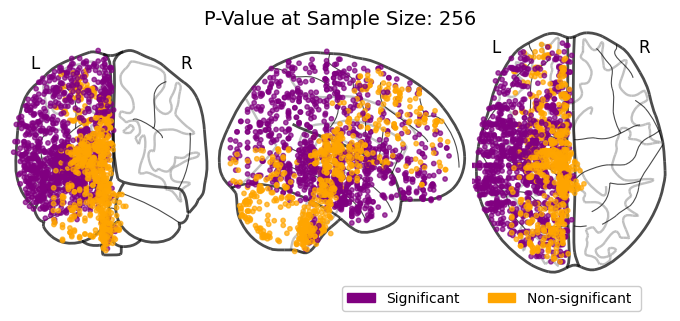

In [18]:
# Drop rows with missing MNI coordinates
df_p = df_p.dropna(subset=['mni_x', 'mni_y', 'mni_z'])

# Extract MNI coordinates
mni_coords = df_p[['mni_x', 'mni_y', 'mni_z']].values

# Define the range of sample sizes
range_with_powers_of_two = [2**i for i in range(3, 9)]

# Create a custom colormap with softer colors
# Significant p-values (p < 0.05) will be salmon, non-significant will be lightblue
cmap = mcolors.ListedColormap(['purple', 'orange'])
bounds = [0, 0.05, 1]  # p < 0.05 (salmon), p >= 0.05 (lightblue)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create legend handles
significant_patch = mpatches.Patch(color='purple', label='Significant')
non_significant_patch = mpatches.Patch(color='orange', label='Non-significant ')

# Loop through the sample sizes and create plots
for i in range_with_powers_of_two:
    # Choose a p-value column to use for the colormap
    sample_size = "p-value_" + str(i)
    p_values = df_p[sample_size].values

    # Plot the brain with the points, using p-values for the colormap
    plotting.plot_markers(
        node_values=p_values,  # Use p-values for the colormap
        node_coords=mni_coords,    # MNI coordinates
        colorbar=False,            # Disable colorbar
        node_cmap=cmap,            # Use the custom colormap
        node_size=10,              # Adjust the size of the markers
        node_vmin=0,               # Minimum p-value
        node_vmax=1                # Maximum p-value
    )
    
    # Add title
    plt.suptitle(f'P-Value at Sample Size: {i}', fontsize=14, y=1.05)
    
    plt.legend(
        handles=[significant_patch, non_significant_patch],
        loc='upper center',        # Position the legend at the top center
        bbox_to_anchor=(0.1, -0.0), # Move the legend below the plot
        ncol=2,                     # Arrange legend items in a single row
        framealpha=1                # Make the legend background opaque
    )    
plt.show()


### Saving it as a .GIF animtion

In [19]:
import os
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from nilearn import plotting

# Drop rows with missing MNI coordinates
df_p = df_p.dropna(subset=['mni_x', 'mni_y', 'mni_z'])

# Extract MNI coordinates
mni_coords = df_p[['mni_x', 'mni_y', 'mni_z']].values

# Define the range of sample sizes
range_with_powers_of_two = [2**i for i in range(3, 9)]

# Create a custom colormap
cmap = mcolors.ListedColormap(['purple', 'orange'])
bounds = [0, 0.05, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create legend handles
significant_patch = mpatches.Patch(color='purple', label='Significant')
non_significant_patch = mpatches.Patch(color='orange', label='Non-significant')

# Create a folder for saving images
output_folder = "brain_plots"
os.makedirs(output_folder, exist_ok=True)

# Store filenames for the GIF
image_filenames = []

# Loop through the sample sizes and create plots
for i in range_with_powers_of_two:
    plt.figure(figsize=(6, 6))  # Ensure consistent figure size
    
    # Choose a p-value column to use for the colormap
    sample_size = "p-value_" + str(i)
    p_values = df_p[sample_size].values

    # Plot the brain with markers
    plotting.plot_markers(
        node_values=p_values,
        node_coords=mni_coords,
        colorbar=False,
        node_cmap=cmap,
        node_size=10,
        node_vmin=0,
        node_vmax=1
    )
    
    # Add title
    plt.suptitle(f'P-Value at Sample Size: {i}', fontsize=14, y=1.05)
    
    # Add legend
    plt.legend(
        handles=[significant_patch, non_significant_patch],
        loc='upper center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=2,
        framealpha=1
    )

    # Save the frame
    filename = os.path.join(output_folder, f"frame_{i}.png")
    plt.savefig(filename, bbox_inches='tight')
    plt.close()
    image_filenames.append(filename)

# Create GIF
gif_filename = PLOTS_PTH / Path("p-value-brain-animation.gif")
imageio.mimsave(gif_filename, [imageio.imread(img) for img in image_filenames], duration=0.8)



/tmp/ipykernel_2360588/394017755.py:72: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave(gif_filename, [imageio.imread(img) for img in image_filenames], duration=0.8)


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

Plotting Helpers

In [22]:
def plot_cluster(cluster, effect_size='effect_size_256', title=None):
    # Extract coordinates and effect sizes
    coords = cluster[['mni_x', 'mni_y', 'mni_z']].values
    effect_sizes = cluster['effect_size_256'].values
    
    # Load template and get affine transformation
    template = load_mni152_template()
    affine = template.affine
    
    # Initialize empty volume with template dimensions
    data = np.zeros(template.shape)
    
    # Create a small sphere around each coordinate point
    for i, (x, y, z) in enumerate(coords):
        # Convert MNI coordinates to voxel coordinates using affine transformation
        vox_coords = nib.affines.apply_affine(np.linalg.inv(affine), 
                                            np.array([[x, y, z]]))
        vox_coords = np.round(vox_coords[0]).astype(int)
        
        # Ensure coordinates are within bounds
        if (0 <= vox_coords[0] < data.shape[0] and 
            0 <= vox_coords[1] < data.shape[1] and 
            0 <= vox_coords[2] < data.shape[2]):
            
            # Create a small sphere (radius = 3 voxels) around the point
            xx, yy, zz = np.ogrid[-3:4, -3:4, -3:4]
            sphere = (xx**2 + yy**2 + zz**2 <= 3**2)
            
            # Get coordinates for the sphere
            x_coords = np.clip(vox_coords[0] + xx, 0, data.shape[0]-1)
            y_coords = np.clip(vox_coords[1] + yy, 0, data.shape[1]-1)
            z_coords = np.clip(vox_coords[2] + zz, 0, data.shape[2]-1)
            
            # Add the effect size to the sphere region
            data[x_coords, y_coords, z_coords] = np.where(sphere, effect_sizes[i], data[x_coords, y_coords, z_coords])
    
    # Create new image with the same affine as the template
    effect_img = new_img_like(template, data, affine=affine)
    
    # Create the display
    display = plotting.plot_glass_brain(
        effect_img,
        display_mode='ortho',
        colorbar=True,
        threshold=0.0
    )
    return display


def create_cluster_image(cluster_data, effect_size = 'effect_size_256', fwhm=6):
    """Create a smoothed 3D image for a single cluster based on effect size"""
    # Merge with the expanded coordinates
    # cluster_data = cluster.merge(all_coordinates_expanded, 
    #                            left_on='brain_region', 
    #                            right_on='structure_id')
    
    # Use the _y coordinates (from all_coordinates_expanded)
    coords = cluster_data[['mni_x', 'mni_y', 'mni_z']].values
    effect_sizes = cluster_data['effect_size_256'].values  # Use the effect size values
    
    # Load template and get affine transformation
    template = load_mni152_template()
    affine = template.affine
    
    # Initialize empty volume
    data = np.zeros(template.shape)
    
    # Create a sphere for each coordinate, with color based on effect size
    for i, (x, y, z) in enumerate(coords):
        color_value = effect_sizes[i]  # Assign color based on effect size
        
        # Convert MNI coordinates to voxel coordinates
        vox_coords = nib.affines.apply_affine(np.linalg.inv(affine), 
                                            np.array([[x, y, z]]))
        vox_coords = np.round(vox_coords[0]).astype(int)
        
        # Ensure coordinates are within bounds
        if (0 <= vox_coords[0] < data.shape[0] and 
            0 <= vox_coords[1] < data.shape[1] and 
            0 <= vox_coords[2] < data.shape[2]):
            
            # Create a small sphere around the point
            xx, yy, zz = np.ogrid[-3:4, -3:4, -3:4]
            sphere = (xx**2 + yy**2 + zz**2 <= 2**2)
            
            # Get coordinates for the sphere
            x_coords = np.clip(vox_coords[0] + xx, 0, data.shape[0]-1)
            y_coords = np.clip(vox_coords[1] + yy, 0, data.shape[1]-1)
            z_coords = np.clip(vox_coords[2] + zz, 0, data.shape[2]-1)
            
            # Set the sphere value
            data[x_coords, y_coords, z_coords] = np.where(sphere, color_value, data[x_coords, y_coords, z_coords])
    
    # Create image
    img = new_img_like(template, data, affine=affine)
    
    # Apply smoothing
    smoothed_img = smooth_img(img, fwhm=fwhm)
    
    return smoothed_img


Creating Images for interesting regions 

In [38]:

columns = [f"effect_size_{sample_size}" for sample_size in range_with_powers_of_two]

cluster_0_stats_br = cluster_0_stats.groupby('brain_region')[columns].mean().reset_index()
cluster_1_stats_br = cluster_1_stats.groupby('brain_region')[columns].mean().reset_index()
cluster_2_stats_br = cluster_2_stats.groupby('brain_region')[columns].mean().reset_index()

df_stats_br = df_stats.groupby('brain_region')[columns].mean().reset_index()
df_stats_br.head(3)

# Instead of taking the mean, keep all coordinates for each structure
all_coordinates = donors_sa_df.groupby('structure_id').agg({
    'mni_x': list,
    'mni_y': list,
    'mni_z': list
}).reset_index()

# Function to explode the lists of coordinates back into rows
def expand_coordinates(row):
    return pd.DataFrame({
        'structure_id': [row['structure_id']] * len(row['mni_x']),
        'mni_x': row['mni_x'],
        'mni_y': row['mni_y'],
        'mni_z': row['mni_z']
    })

# Expand the coordinates
all_coordinates_expanded = pd.concat(
    [expand_coordinates(row) for _, row in all_coordinates.iterrows()],
    ignore_index=True
)


# Merge cluster data with MNI coordinates
cluster1 = cluster_0_stats_br.merge(all_coordinates_expanded, left_on='brain_region', right_on='structure_id')
cluster2 = cluster_1_stats_br.merge(all_coordinates_expanded, left_on='brain_region', right_on='structure_id')
cluster3 = cluster_2_stats_br.merge(all_coordinates_expanded, left_on='brain_region', right_on='structure_id')

df_stats_br_mni = df_stats_br.merge(all_coordinates_expanded, left_on='brain_region', right_on='structure_id')


# Create separate images for each cluster with different values
cluster1_img = create_cluster_image(cluster1, 1)  # Value 1 for cluster 1
cluster2_img = create_cluster_image(cluster2, 2)  # Value 2 for cluster 2
cluster3_img = create_cluster_image(cluster3, 3)  # Value 3 for cluster 3

cluster1

brain_region  effect_size_8  effect_size_16  effect_size_32  \
0             4014       0.763522        0.353605        0.380905   
1             4014       0.763522        0.353605        0.380905   
2             4014       0.763522        0.353605        0.380905   
3             4014       0.763522        0.353605        0.380905   
4             4014       0.763522        0.353605        0.380905   
...            ...            ...             ...             ...   
1202         13005      -0.539211       -0.518028       -0.557842   
1203         13005      -0.539211       -0.518028       -0.557842   
1204         13005      -0.539211       -0.518028       -0.557842   
1205         13005      -0.539211       -0.518028       -0.557842   
1206         13005      -0.539211       -0.518028       -0.557842   

      effect_size_64  effect_size_128  effect_size_256  structure_id  mni_x  \
0           0.385458         0.378387         0.252974          4014  -50.6   
1           0.385458         0.378387         0.252974          4014  -28.4   
2           0.385458         0.378387         0.252974          4014   -5.9   
3           0.385458         0.378387         0.252974          4014  -43.0   
4           0.385458         0.378387         0.252974          4014  -61.0   
...              ...              ...              ...           ...    ...   
1202       -0.600964        -0.439613        -0.364578         13005  -10.0   
1203       -0.600964        -0.439613        -0.364578         13005    3.0   
1204       -0.600964        -0.439613        -0.364578         13005  -11.0   
1205       -0.600964        -0.439613        -0.364578         13005   -7.0   
1206       -0.600964        -0.439613        -0.364578         13005   -4.0   

      mni_y  mni_z  
0       5.7    6.8  
1      -8.5   58.9  
2     -26.2   75.9  
3     -17.0   67.0  
4      -6.0   40.0  
...     ...    ...  
1202   -7.0   -4.0  
1203  -18.3   -5.9  
1204    0.0   -6.0  
1205   -9.0  -13.0  
1206   -3.0  -12.0  

[1207 rows x 11 columns]

Plotting Effect Size on brain regions

/home/affectiva/.cache/pypoetry/virtualenvs/src-Ccial1dq-py3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


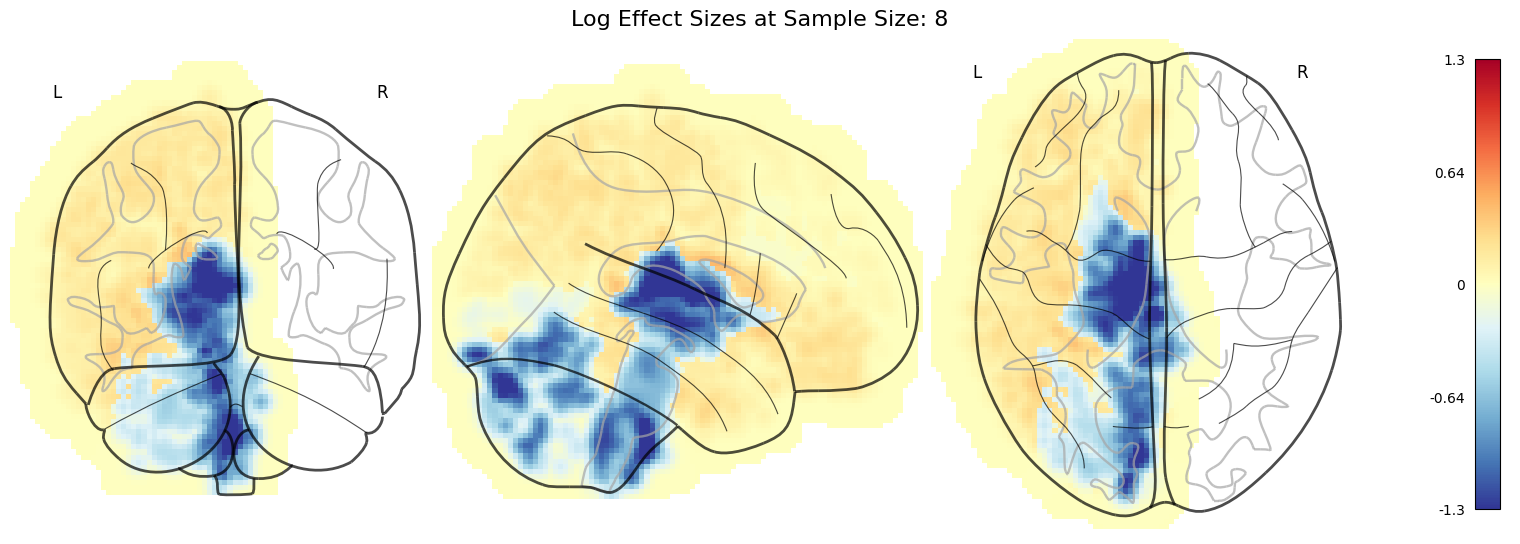

/home/affectiva/.cache/pypoetry/virtualenvs/src-Ccial1dq-py3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


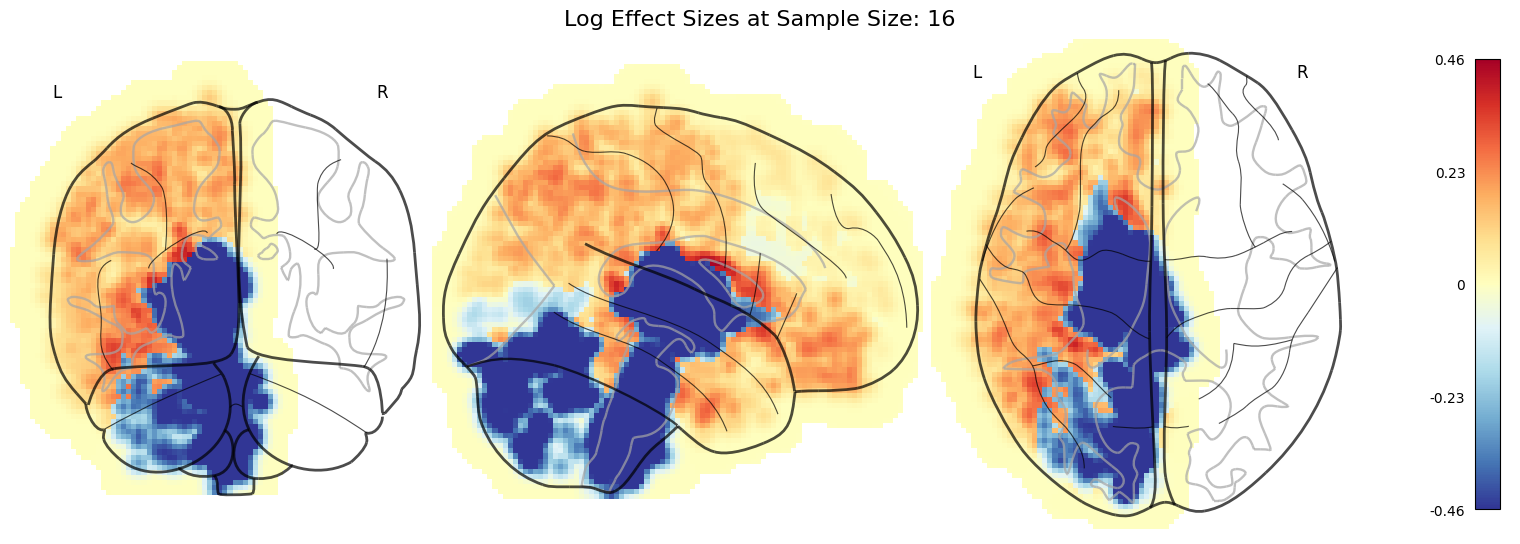

/home/affectiva/.cache/pypoetry/virtualenvs/src-Ccial1dq-py3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


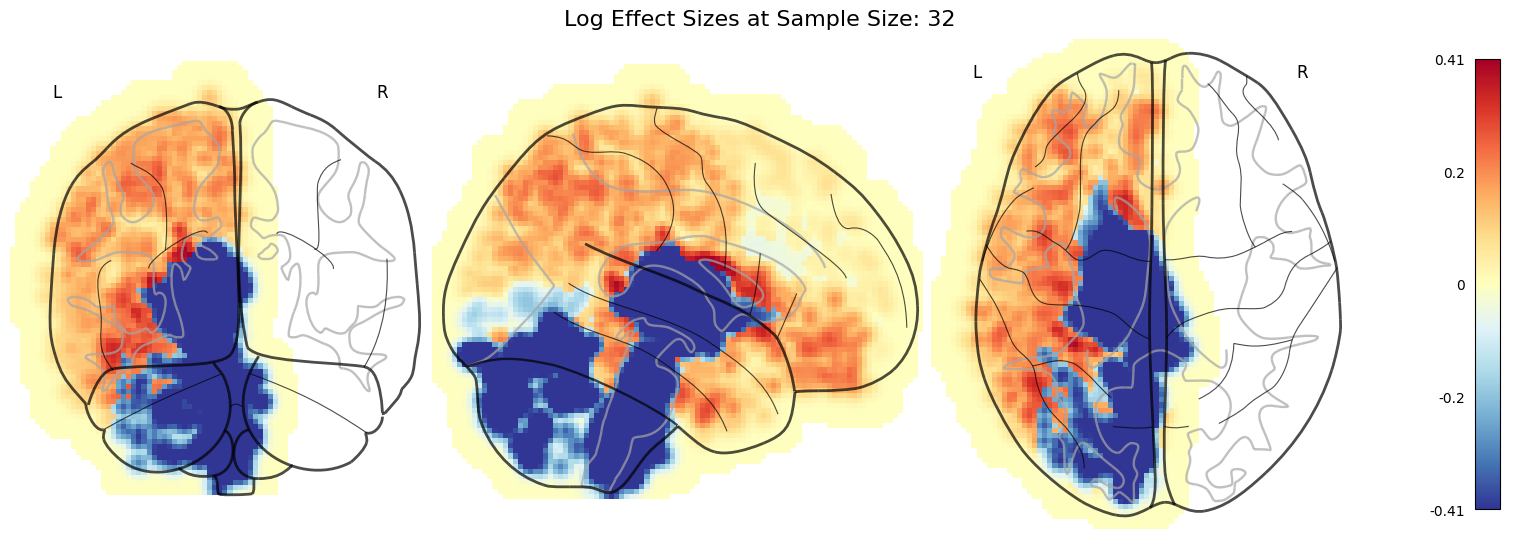

/home/affectiva/.cache/pypoetry/virtualenvs/src-Ccial1dq-py3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


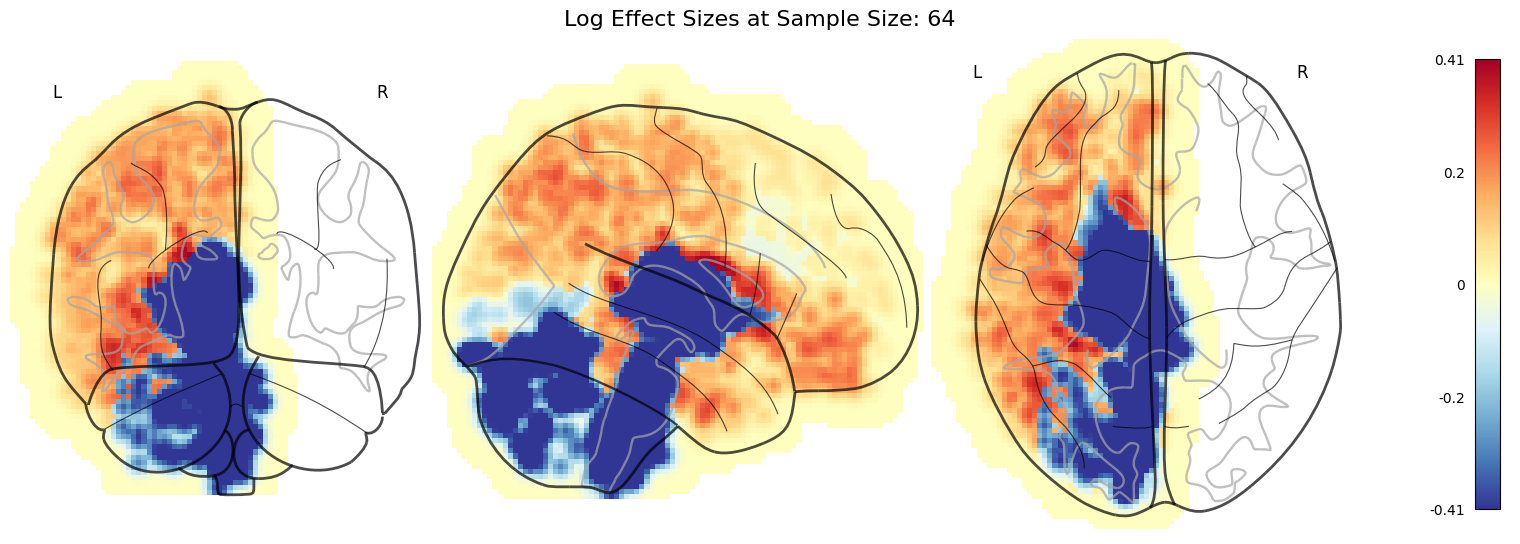

/home/affectiva/.cache/pypoetry/virtualenvs/src-Ccial1dq-py3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


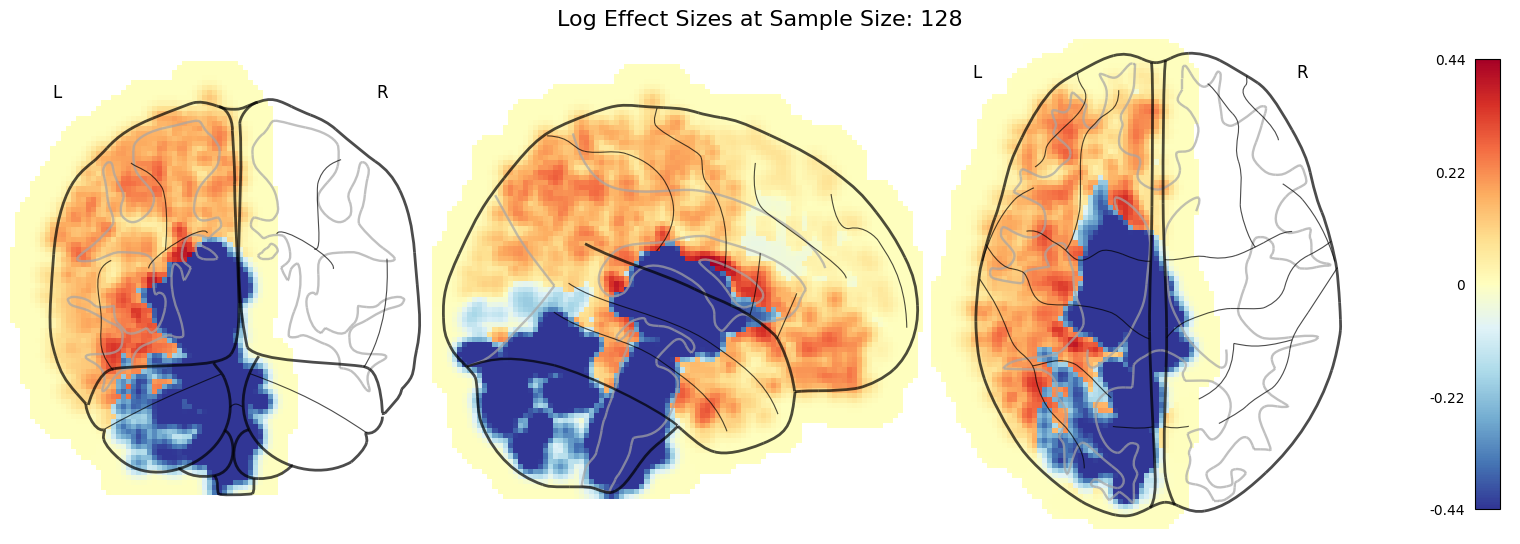

/home/affectiva/.cache/pypoetry/virtualenvs/src-Ccial1dq-py3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


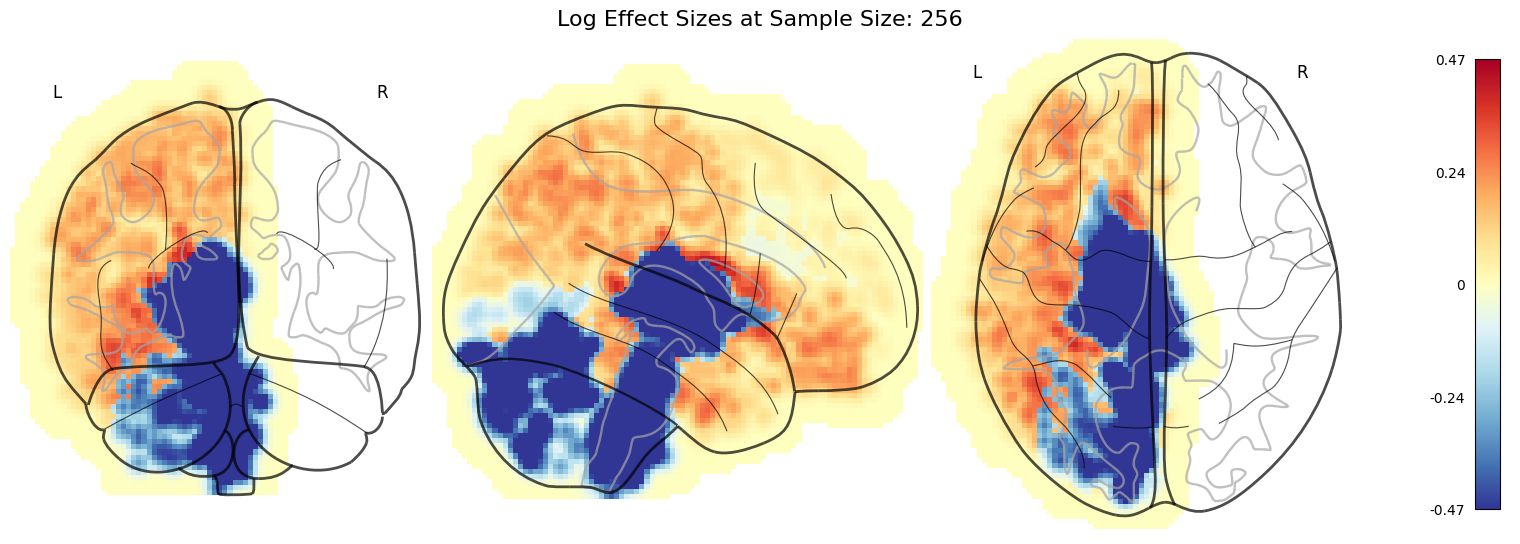

In [48]:
for sample_size in range_with_powers_of_two:
    # Extract effect size column and apply log transformation
    effect_size_col = f"effect_size_{sample_size}"
    
    # Ensure the column exists in the DataFrame
    if effect_size_col not in df_stats_br_mni.columns:
        print(f"Warning: {effect_size_col} not found in DataFrame.")
        continue
    
    # Apply log transformation, using log1p to handle small values safely
    df_stats_br_mni[f"log_{effect_size_col}"] = np.log1p(df_stats_br_mni[effect_size_col])
    
    # Generate the brain image using the transformed effect sizes
    all_regions = create_cluster_image(df_stats_br_mni, effect_size=f"log_{effect_size_col}")

    # Create a figure
    plt.figure(figsize=(15, 5))
    
    # Determine effect size limits for consistent scaling
    vmin = np.min(df_stats_br_mni[f"log_{effect_size_col}"])
    vmax = np.max(df_stats_br_mni[f"log_{effect_size_col}"])

    # Plot the brain effect sizes
    display = plotting.plot_glass_brain(
        all_regions,
        display_mode='ortho',
        cmap=plt.cm.RdYlBu_r,  # Custom colormap
        colorbar=True,
        plot_abs=False,
        figure=plt.gcf(),
        threshold=0.0,  # Adjust threshold for smoother edges
        vmin=vmin, vmax=vmax  # Normalize effect size visualization
    )

    plt.suptitle(f'Log Effect Sizes at Sample Size: {sample_size}', fontsize=16, y=1.05)

    # Show the plot
    plt.show()
    plt.close()



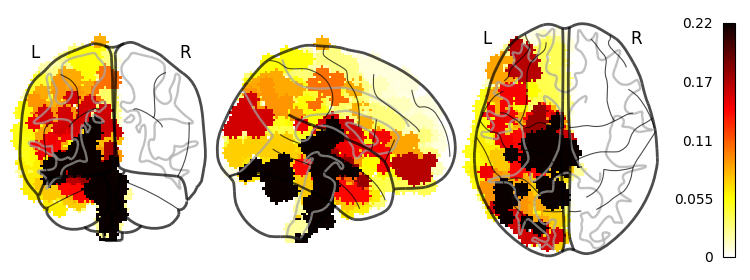

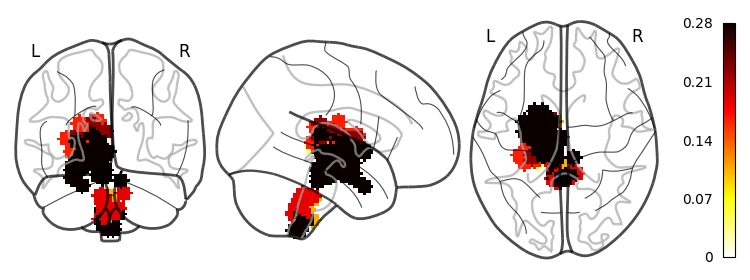

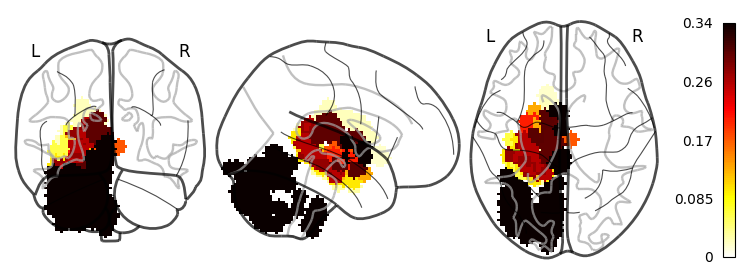

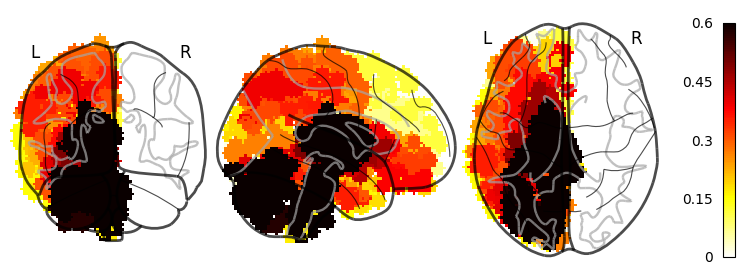

In [172]:
plot_cluster(cluster1,'effect_size_256')
plot_cluster(cluster2,'effect_size_256')
plot_cluster(cluster3,'effect_size_256')
plot_cluster(df_stats_br_mni,'effect_size_256')
# Show the plots
plotting.show()

In [55]:
cluster_0 = load_df_from_csv(PROCESSED_DONORS_GE_PATH / Path('cluster_0_filtered.csv'))
cluster_1 = load_df_from_csv(PROCESSED_DONORS_GE_PATH / Path('cluster_1_filtered.csv'))
cluster_2 = load_df_from_csv(PROCESSED_DONORS_GE_PATH / Path('cluster_2_filtered.csv'))
ontology = load_df_from_csv(PROCESSED_DONORS_GE_PATH / Path('Ontology.csv'))

In [60]:
# Assuming 'df' is your DataFrame
cluster_0_brain_regions_list = cluster_0["brain_region"].unique().tolist()
cluster_1_brain_regions_list = cluster_1["brain_region"].unique().tolist()
cluster_2_brain_regions_list = cluster_2["brain_region"].unique().tolist()

cluster_brain_regions = {
    0 : cluster_0_brain_regions_list,
    1 : cluster_1_brain_regions_list,
    2 : cluster_2_brain_regions_list    
}

cluster_brain_regions_names = {}

cluster_0_brain_regions, cluster_1_brain_regions, cluster_2_brain_regions = [],[],[]
cluster_brain_regions_names = {
    0 : cluster_0_brain_regions,
    1 : cluster_1_brain_regions,
    2 : cluster_2_brain_regions    
}
for i in range(0,3):
    for br in cluster_brain_regions[i]:
        cluster_brain_regions_names[i].append(ontology.loc[ontology['id'] == br, 'name'].str.split(",", n=1).str[0].tolist()[0])



with open(OUTPUT_DATA / Path("cluster_0_brain_region_names.txt"), 'w') as f:
    for line in cluster_brain_regions_names[0]:
        f.write(f"{line}\n")


with open(OUTPUT_DATA / Path("cluster_1_brain_region_names.txt"), 'w') as f:
    for line in cluster_brain_regions_names[1]:
        f.write(f"{line}\n")
        
with open(OUTPUT_DATA / Path("cluster_2_brain_region_names.txt"), 'w') as f:
    for line in cluster_brain_regions_names[2]:
        f.write(f"{line}\n")
